# Introduction
Fair algorithms are designed to remove unwanted impacts of protected attributes such as gender or ethnicity  on automatic decisions. 
Early fairness aware machine learning methods viewed fairness from a static point of view and did not consider the impact of decisions on the future.

Recently, long term impacts and dynamics of decisions moved into the focus and the long term effects of decisions have been studied. 
Some of the key insight are, that decisions that appear to be fair from a static point of view may have negative long term impact. An example could be a hiring scenario, where the decision maker is forced the hire a certain amount of people from a protected group without considering their qualification (i.e. hire at least 10 people from group $a$ regardless of their qualification). The decision maker could in this case learn, that applicants from group $a$ are unqualified in general and avoid them if the fairness restriction is removed at some time.   

This student project develops a framework to simulate the impacts of static decision rules on long term fairness under different assumptions regarding the data generation process. The framework is designed to work with the AIF360 framework, to provide out of the box access to fairness metrics and algorithms.

Data is generated sequentially assuming an impact of the features of the previous time step on the current features. Two different assumptions about the data generation are made in the project:

1. Only the individual with a positive decision benefits from this decision in the next iteration.
2. All individuals from the same group benefit from positive decision.

Depending on the assumptions regarding the data generation process static decision rules have different impact on the long term dynamics.

In [5]:
import sys
sys.path.append("../")

import numpy as np

from sklearn.svm import LinearSVC, SVC
from long_term_fairness.ltf_plot import LongTermFairnessPlot
from long_term_fairness.ltf_data.naive_individual_data_generator import DataGenerator

import warnings
warnings.filterwarnings("ignore")

# 1. Fairness in Machine Learning

The default setup of machine learning...

Features $$X \in \mathbb{R}^{n \times m}$$

True labels $$y \in \mathbb{R}^{n} $$

Predictions $$\hat{y} \in \mathbb{R}^{n} $$

decision function $$d~: X \rightarrow \hat{y}$$

error function $$\mathcal{L}~: \hat{y} \times y \rightarrow \mathbb{R}$$

The optimal decision function $d^*$ is found by minimizing error function:

$$\min_d \mathcal{L}(\hat{y}, y)$$


## 1.1 Static Fairness Setup
In fairness aware machine learning, some features $A \in \mathbb{R}^{n \times k} $ are considered protected (e.g. describing ethnicity, gender or age). Here, the protected features are not contained in the features $X$ ($A \notin X$). The new decision function $d'$ now is a function of two parameters:

$$d' : X \times A \rightarrow \hat{y}$$

$d'$ must satisfy fairness for the protected features with respect to some fairness measure $f$. Two example metrics are discussed in chapter 1.3.

The following part briefly describes, how such a decision function can be found. 


### 1.1.1 Finding Fair Decision Rules

Three different approaches can be used for constructing fair decision rules:

#### 1. Pre-Processing
The features $X$ and $A$ are changed such that the resulting data $X_f, A_f$ has no unfairness. 

#### 2. In-Processing
The learning is adopted, such that the learned decision function $d$ is fair. This can for instance be achieved by extending the loss function with a penalty term w.r.t. to the desired definition of fairness.

#### 3. Post-Processing
A learned decision function $d$ is adjusted such that the output of the new function $g \circ d$ is fair.

## 1.2. Long Term Fairness Setup
The above setup defines fairness for a static (one shot) decision process. 

In the dynamic or long term decision process $X, A, Y, \hat{Y}$ are aggregated over time and are 3D tensors now. The superscript $^{(t)}$ indicates that feature matrix at time step $t$ is meant.

$$ Y^{(t)} \in \mathbb{R}^{n}$$
$$ \hat{Y}^{(t)} \in \mathbb{R}^{n}$$
$$A^{(t)} = A \in \mathbb{R}^{n}$$
$$X^{(t)} \in \mathbb{R}^{n \times m}$$

$$Y \in \mathbb{R}^{t \times n}$$
$$\hat{Y}\in \mathbb{R}^{t \times n}$$
$$X\in \mathbb{R}^{t \times n \times m}$$


## 1.3 Measuring Static Fairness
Two metrics $f$ are used as examples in this project and discussed here. There are several ways to describe fairness in terms of a function $f$. In general, the metric $f$ can be any function mapping a subset $ \mathcal{M} \in \{X^{(t)},A^{(t)},Y^{(t)},\hat{Y}^{(t)} \}$ to a real value representing the fairness:

$$ f: \mathcal{M} \in \{X,A,Y,\hat{Y}\} \rightarrow \mathbb{R}$$

Metrics can roughly be categorized using the input signatures. All fairness metrics will take the protected features $A$ as input since these are the features for which fairness is desired. 

If metrics take error rates into consideration, they will need the true labels $Y$ and predictions $\hat{Y}$. If $X$ is required as input, the metric would care about similarity of individuals.

Detailed descriptions and discussions an be found in the [fairmlBook](https://fairmlbook.org/pdf/classification.pdf). 

### 1.3.1 Disparate Impact (or Demographic Parity)
Disparate Impact is one of the first metrics considered in fair machine learning. It only considers the acceptance rates and requires that the number of positive labeled individuals between all protected groups must roughly be the same.

Using probability distributions to describe disparate impact yields the following definition:

$$P(\hat{Y}^{(t)} = \hat{y} | A = a_i) = P(\hat{Y}^{(t)} = \hat{y} | A = a_j) ~~ \forall i, j $$ 

A notation that can be implemented as function  $f: \hat{Y}^{(t)} \times A^{(t)} \rightarrow \mathbb{R}$ assuming a binary attribute $A$ would be:

$$f(\hat{Y}^{(t)}, A^{(t)})= \sum_{i =0}^{n} \frac{ \mathbf{1}_1(a_i^{(t)}) \cdot y_i^{(t)}}{ \mathbf{1}_0(a_i^{(t)}) \cdot y_i^{(t)}} $$

Here, $1$ is considered to be the positive label and $\mathbf{1}_1(a_i)$ is the indicator function for the positive class and $\mathbf{1}_0(a_i)$ for the negative class respectively. 

Limits of disparate impact are for instance laziness. A decision function trying to satisfy disparate impact might simply accept individuals with a true negative label simply to satisfy disparate impact. Another limitation often mentioned is, that disparate impact rules out the perfect classifier as shown in the figure below.

In [28]:
# Fair artificial decision satisfying disparate impact.
class DisparateImpactFairCLF:
    def predict(self, X, X_s):
        pred = [10, 10] @ X.T -50
        
        pred[pred>0] = 1
        pred[pred<0] = 0
        
        return np.sign(pred)
    def fit(self, X, X_s, y):
        pass

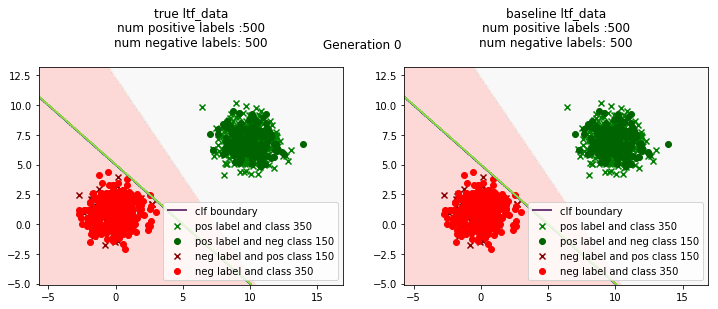

In [29]:
generator = DataGenerator()
clf = DisparateImpactFairCLF()
l = LongTermFairnessPlot(generator, clf, None)

l.init_data()
l.plot_generation()

The data in above plot 

### 1.3.2  Error based Metrics (Equal Opportunity or Separation)
Error based metrics also consider the true label $Y$ and the predictions $\hat{Y}$.
In general, they require that error rates should be minimized. Depending on the scenario one might by interested in overall error rates, false positive/negatives, recall or omissions. 

The definition as probability distribution would be:
$$P(\hat{Y}^{(t)} = \hat{y} | Y = y, A = a_i ) = P(\hat{Y}^{(t)} = \hat{y} | Y=y, A = a_j) ~~ \forall i, j $$ 

One limit if error based metrics is, that a decision maker can trade off error rates between groups. For example, instead of improving the the accuracy for the protected group the decision maker could simply miss label some individuals of the unprotected group. Compared to disparate impact, error based metrics accept a perfect decision maker since it does not make errors.

In [ ]:
# Fair artificial decision satisfying disparate impact.
class EOFairCLF:
    def predict(self, X, X_s):
        pred = [5, 12] @ X.T -50
        
        pred[pred>0] = 1
        pred[pred<0] = 0
        
        return np.sign(pred)
    def fit(self, X, X_s, y):
        pass

In [ ]:
generator = DataGenerator()
clf = EOFairCLF()
l = LongTermFairnessPlot(generator, clf, None)

l.init_data()
l.plot_generation()

The EO boundary only miss classifies ...

# 2. Limits of above Metrics
The above two methods are referred to as observational. They can be expressed as probability distributions over the random variables $X^{(t)}, Y^{(t)}, \hat{Y}^{(t)}$ and $A^{(t)}$. More limitations are discussed in the chapter [Inherent limitations of observational criteria](https://fairmlbook.org/pdf/causal.pdf) of the fair ML book. 

The limitations addressed here  are related to long term fairness. A decision made at some time point $t$ in this framework has an impact on the future.  Similar to the reasoning in [Delayed Impact](https://arxiv.org/abs/1803.04383), a static decision rule can have different impacts on the future depending on the assumptions about the data generation process.

The data and specifically the true labels $Y$ in the long term decision process is assumed to be distributed proportional to the number of past positive predictions for sub groups $G$ influencing each individual. $$P(y_i^{(t)}=1) \sim \sum _ {j \in G} \sum _ {i=1} ^{n} \hat{y} _j ^{(t-n)} $$

$G$ is a degree of freedom and motivated by reasoning that the social environment has an impact on each individual. For instance, if parents graduated from university children are almost twice as likely to graduate themselves [](). Friends or public figures can also motivate someone by serving as role models. If members of a protected group are for instance accepted for university or employed in high positions other members of this group might be motivated to do so as well.

Long term effects are not explicitly considered in static metrics. Nevertheless, they can have impact on long term fairness. It is, however, not directly possible to apply static metrics to the long term data. One could for instance compute disparate impact on the aggregated data $X, Y, \hat{Y}, A$, but this generalizes to the average disparate impact over each generation and does not take the dynamics into account. 

Consider a perfect decision function (one that makes no errors). From a static point of view, such a function could be considered as fair (i.e. it would satisfy all error based metrics). Under aboves assumption, such a decision rule  would never change the underlining data distribution. The number of individuals from each group labeled negative and positive would stay constant over time. However, if more individuals from the negative labeled group would have been given a chance, the overall number of positive labeled individuals would have increased.

It can be argued, that the decision marker itself has an interest in increasing the pool of qualified individuals to have an better chance of hiring someone. 

In this setup, the effect of a static decision rule depends on the assumption about the underlining data generation. Two different assumptions about the group of individuals $G$ influencing the data generation process are implemented.

1. Positive predictions only influence the individual itself, which would be $G=\{i\}$.

2. The whole group benefits from positive predictions $G=\{j | a_j=a_i\}$.

They are discussed in the notebooks of chapter 2.

Until now it was only stated that static fairness metrics do not qualify for measuring long term fairness.
This is because the long term view implies other fairness notations beyond static criteria. Since the ability of individuals can improve as consequence of previous decisions, the question is shifted from *is an individual qualified today* to *could the individual be qualified in future*. The most intuitive way to define long term fairness would be, to state that the decision function must maximize he number of positive labeled individuals in future.

This view can be seen as related or as a subtype of causal fairness criteria. Before a definition for long term fairness is described it is compared to causal fairness definitions.

## 2.1 Causal Fairness
Causal fairness notations ask *why* individuals are labeled as they are [fairmlBook](https://fairmlbook.org/pdf/causal.pdf). A label is considered as unfair if a protected attribute has an undesired effect on the decision.

The relationship between variables can be visualized with cause effect graphs.

$$TODO$$


A decision is considered as unfair as soon as ...

The data generation process assumed in the long term setup could be drawn as follows:

$$TODO$$

## 2.2 Defining Long Term Fairness
The best way to conceptually define fairness in a long term decision process is trough the number of qualified individuals after several decision steps denoted: $$ \# (Y^{(t)}=1)$$

The goal of this project is to show the effects of static decision function on long term fairness. Therefore, the long term metric is not used here. Effects are compared to baseline data assuming, that 

Long term fairness as described here and decision maker utility (usually accuracy) are kind of parallel notations.
The decision maker must accept some false decision in order to achieve long term fairness. However, as discussed later the decision maker on the other hand has an interest in increasing the number of qualified individuals.

## 2.3 Long Term Decision Function
The framework is used here to visualize the effects of different  short term decision functions on the long term effect. It is also designed to provide a possibility to train a decision function learning the long term relationship.

A possible extension of the fairness in ML setup could be to extend the notation of the decision makers utility by the number of qualified individuals in the future. I.e. the decision maker does not only want to correctly label all qualified candidates in the current decision process but also to increase the number of qualified people for the future.

$$max(U)$$

$$U \sim \mathbb{E}[Y^{(t)}=\hat{Y}^{(t)}] +  \sum_{i=1} ^N \mathbb{E}[\# (Y^{(t+i)}=1)]$$



## 2.4 Related Work
Long term fairness has gained much interest recently...

https://github.com/google/ml-fairness-gym long term fairness as markov decision process

https://arxiv.org/abs/1909.09141 Causal Modeling for Fairness in Dynamical Systems

https://arxiv.org/abs/1803.04383 Delayed Impact of Fair Machine Learning

https://arxiv.org/abs/1903.01209 On the Long-term Impact of Algorithmic Decision Policies

https://arxiv.org/abs/1712.00064 A Short-term Intervention for Long-term Fairness in the Labor Market